In [36]:
%cd C:\Users\John\Documents\Research\ML_Gravity\

C:\Users\John\Documents\Research\ML_Gravity


In [29]:
import os

os.environ["PATH"] += os.pathsep + "C:\\Program Files\\NVIDIA GPU Computing Toolkit\\CUDA\\v10.1\\extras\\CUPTI\\lib64"

import copy
import pickle
import sys
import time

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.io
import tensorflow as tf
#import tensorflow_model_optimization as tfmot
from GravNN.CelestialBodies.Asteroids import Bennu, Eros
from GravNN.CelestialBodies.Planets import Earth
from GravNN.Networks.Configs.Default_Configs import *
from GravNN.Networks.Configs.Fast_Configs import *
from GravNN.GravityModels.Polyhedral import Polyhedral, get_poly_data
from GravNN.GravityModels.SphericalHarmonics import (SphericalHarmonics,
                                                     get_sh_data)
from GravNN.Networks import utils
from GravNN.Networks.Analysis import Analysis
from GravNN.Networks.Callbacks import CustomCallback
from GravNN.Networks.Compression import (cluster_model, prune_model,
                                         quantize_model)
from GravNN.Networks.Data import generate_dataset, training_validation_split
from GravNN.Networks.Model import CustomModel, load_config_and_model
from GravNN.Networks.Networks import (DenseNet, InceptionNet, ResNet,
                                      TraditionalNet)
from GravNN.Networks.Plotting import Plotting
from GravNN.Support.Grid import Grid
from GravNN.Support.transformations import (cart2sph, project_acceleration,
                                            sphere2cart)
from GravNN.Trajectories.DHGridDist import DHGridDist
from GravNN.Trajectories.ExponentialDist import ExponentialDist
from GravNN.Trajectories.GaussianDist import GaussianDist
from GravNN.Trajectories.RandomAsteroidDist import RandomAsteroidDist
from GravNN.Trajectories.RandomDist import RandomDist
from GravNN.Trajectories.FibonacciDist import FibonacciDist

from GravNN.Trajectories.ReducedGridDist import ReducedGridDist
from GravNN.Trajectories.ReducedRandDist import ReducedRandDist
from GravNN.Visualization.MapVisualization import MapVisualization
from GravNN.Visualization.VisualizationBase import VisualizationBase
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from GravNN.Networks.Activations import leaky_relu, bent_identity
from Scripts.Networks.train import train_network
from Scripts.Networks.plot import Plotting

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

# TODO: Put in mixed precision training
# from tensorflow.keras.mixed_precision import experimental as mixed_precision

# policy = mixed_precision.Policy('mixed_float16')
# mixed_precision.set_policy(policy)
# print('Compute dtype: %s' % policy.compute_dtype)
# print('Variable dtype: %s' % policy.variable_dtype)


np.random.seed(1234)
tf.random.set_seed(0)

In [15]:
config = get_fast_earth_config()
config['mixed_precision']

[True]

In [25]:
planet = Earth()
density_deg = 180
test_trajectories = {

    "Brillouin" : DHGridDist(planet, planet.radius, degree=density_deg),
}

In [30]:
    points = 64800
    planet = Earth()
    analysis_trajectories = {
        "Brillouin" : FibonacciDist(planet, planet.radius, points),
        #"LEO" : FibonacciDist(planet, planet.radius+420000.0, points),
    }
    

In [57]:
def pipeline(df_file, config):
    model, config = train_network(df_file, config)

    analyzer = Analysis(model, config)
    model_id = config['id'][0]
    rse_entries = analyzer.compute_rse_stats(analysis_trajectories)
    utils.update_df_row(model_id, df_file, rse_entries)
    print(rse_entries['Brillouin_param_rse_mean'])
    print(rse_entries['Brillouin_rse_mean'])

    print(rse_entries['Brillouin_param_sigma_2_mean'])
    print(rse_entries['Brillouin_sigma_2_mean'])

    plotter = Plotting(model, config)
    plotter.plot_loss()

# Small datasets default behavior

Found existing acceleration.data at C:\Users\John\Documents\Research\ML_Gravity\GravNN\Trajectories\TrajectoryBase/../../Files/Trajectories/RandomDist/earthN_1000000_RadBounds[6378136.6, 6798136.6]/SphericalHarmonics_EGM2008_to2190_TideFree_E_1000/
Found existing acceleration.data at C:\Users\John\Documents\Research\ML_Gravity\GravNN\Trajectories\TrajectoryBase/../../Files/Trajectories/RandomDist/earthN_1000000_RadBounds[6378136.6, 6798136.6]/SphericalHarmonics_EGM2008_to2190_TideFree_E_2/
Epoch: 0 	 Loss: 0.11772 	 Val Loss 0.10437 	 Time: 1.011
Epoch: 10 	 Loss: 0.05346 	 Val Loss 0.05547 	 Time: 0.148
Epoch: 20 	 Loss: 0.05405 	 Val Loss 0.05730 	 Time: 0.147
Epoch: 30 	 Loss: 0.05055 	 Val Loss 0.05411 	 Time: 0.155
Epoch: 40 	 Loss: 0.05047 	 Val Loss 0.05406 	 Time: 0.150
Epoch: 50 	 Loss: 0.05003 	 Val Loss 0.05372 	 Time: 0.145
Epoch: 60 	 Loss: 0.04990 	 Val Loss 0.05356 	 Time: 0.147
Epoch: 70 	 Loss: 0.04979 	 Val Loss 0.05351 	 Time: 0.142
Epoch: 80 	 Loss: 0.04970 	 Val Lo

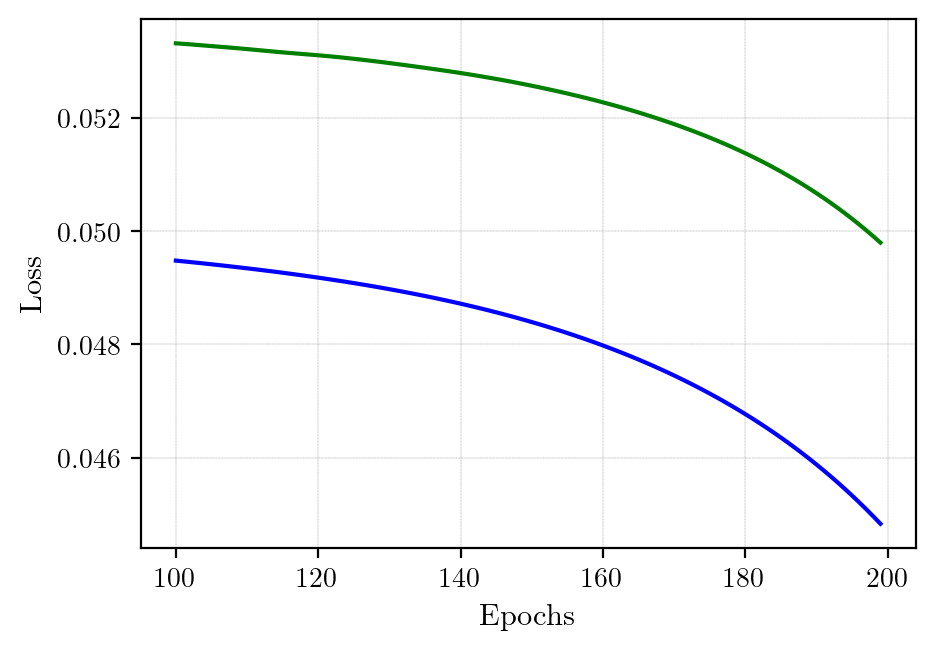

In [58]:
df_file = 'C:\\Users\\John\\Documents\\Research\\ML_Gravity\\Data\\Dataframes\\dummy.data'
#config = get_fast_earth_pinn_config()
config = get_fast_earth_config()
config['epochs'] = [200]
config['batch_size'] = [1024]
config['N_train'] = [1000]
config['PINN_flag'] = ['none']
config['mixed_precision'] = [False]
pipeline(df_file, config)


Found existing acceleration.data at C:\Users\John\Documents\Research\ML_Gravity\GravNN\Trajectories\TrajectoryBase/../../Files/Trajectories/RandomDist/earthN_1000000_RadBounds[6378136.6, 6798136.6]/SphericalHarmonics_EGM2008_to2190_TideFree_E_1000/
Found existing acceleration.data at C:\Users\John\Documents\Research\ML_Gravity\GravNN\Trajectories\TrajectoryBase/../../Files/Trajectories/RandomDist/earthN_1000000_RadBounds[6378136.6, 6798136.6]/SphericalHarmonics_EGM2008_to2190_TideFree_E_2/
Epoch: 0 	 Loss: 0.33440 	 Val Loss 0.21347 	 Time: 4.673
Epoch: 10 	 Loss: 0.09937 	 Val Loss 0.09866 	 Time: 0.220
Epoch: 20 	 Loss: 0.07995 	 Val Loss 0.08288 	 Time: 0.213
Epoch: 30 	 Loss: 0.07292 	 Val Loss 0.07533 	 Time: 0.212
Epoch: 40 	 Loss: 0.06809 	 Val Loss 0.07107 	 Time: 0.209
Epoch: 50 	 Loss: 0.06337 	 Val Loss 0.06628 	 Time: 0.216
Epoch: 60 	 Loss: 0.05955 	 Val Loss 0.06249 	 Time: 0.209
Epoch: 70 	 Loss: 0.05673 	 Val Loss 0.05977 	 Time: 0.219
Epoch: 80 	 Loss: 0.05462 	 Val Lo

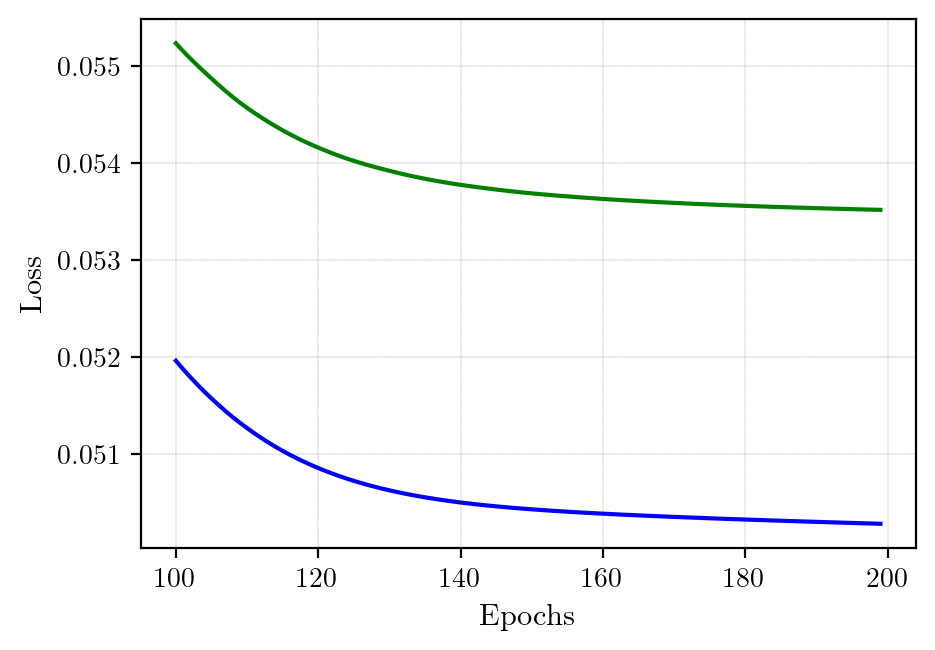

In [59]:
df_file = 'C:\\Users\\John\\Documents\\Research\\ML_Gravity\\Data\\Dataframes\\dummy.data'
#config = get_fast_earth_pinn_config()
config = get_fast_earth_pinn_config()
config['epochs'] = [200]
config['batch_size'] = [1024]
config['N_train'] = [1000]
config['PINN_flag'] = ['laplacian']
config['mixed_precision'] = [False]
pipeline(df_file, config)

# Optimizers and Learning Rates

In [ ]:
df_file = 'C:\\Users\\John\\Documents\\Research\\ML_Gravity\\Data\\Dataframes\\dummy.data'
#config = get_fast_earth_pinn_config()
config = get_fast_earth_pinn_config()
config['epochs'] = [20000]
config['batch_size'] = [1024]
config['N_train'] = [1000]
config['optimizer'] = [tf.keras.optimizers.Adam(lr=0.001)] # 10x
config['PINN_flag'] = ['none']
config['mixed_precision'] = [False]
pipeline(df_file, config)

In [ ]:
df_file = 'C:\\Users\\John\\Documents\\Research\\ML_Gravity\\Data\\Dataframes\\dummy.data'
#config = get_fast_earth_pinn_config()
config = get_fast_earth_pinn_config()
config['epochs'] = [20000]
config['batch_size'] = [1024]
config['N_train'] = [1000]
config['optimizer'] = [tf.keras.optimizers.Adam(lr=0.001)] # 10x
config['PINN_flag'] = ['laplacian']
config['mixed_precision'] = [False]
pipeline(df_file, config)

Found existing acceleration.data at C:\Users\John\Documents\Research\ML_Gravity\GravNN\Trajectories\TrajectoryBase/../../Files/Trajectories/RandomDist/earthN_1000000_RadBounds[6378136.6, 6798136.6]/SphericalHarmonics_EGM2008_to2190_TideFree_E_1000/
Found existing acceleration.data at C:\Users\John\Documents\Research\ML_Gravity\GravNN\Trajectories\TrajectoryBase/../../Files/Trajectories/RandomDist/earthN_1000000_RadBounds[6378136.6, 6798136.6]/SphericalHarmonics_EGM2008_to2190_TideFree_E_2/
Epoch: 0 	 Loss: 0.21255 	 Val Loss 0.14716 	 Time: 4.580
Epoch: 10 	 Loss: 0.09792 	 Val Loss 0.09551 	 Time: 0.221
Epoch: 20 	 Loss: 0.08033 	 Val Loss 0.08231 	 Time: 0.217
Epoch: 30 	 Loss: 0.06915 	 Val Loss 0.07166 	 Time: 0.216
Epoch: 40 	 Loss: 0.06140 	 Val Loss 0.06402 	 Time: 0.223
Epoch: 50 	 Loss: 0.05566 	 Val Loss 0.05862 	 Time: 0.220
Epoch: 60 	 Loss: 0.05241 	 Val Loss 0.05552 	 Time: 0.215
Epoch: 70 	 Loss: 0.05107 	 Val Loss 0.05431 	 Time: 0.219
Epoch: 80 	 Loss: 0.05068 	 Val Lo

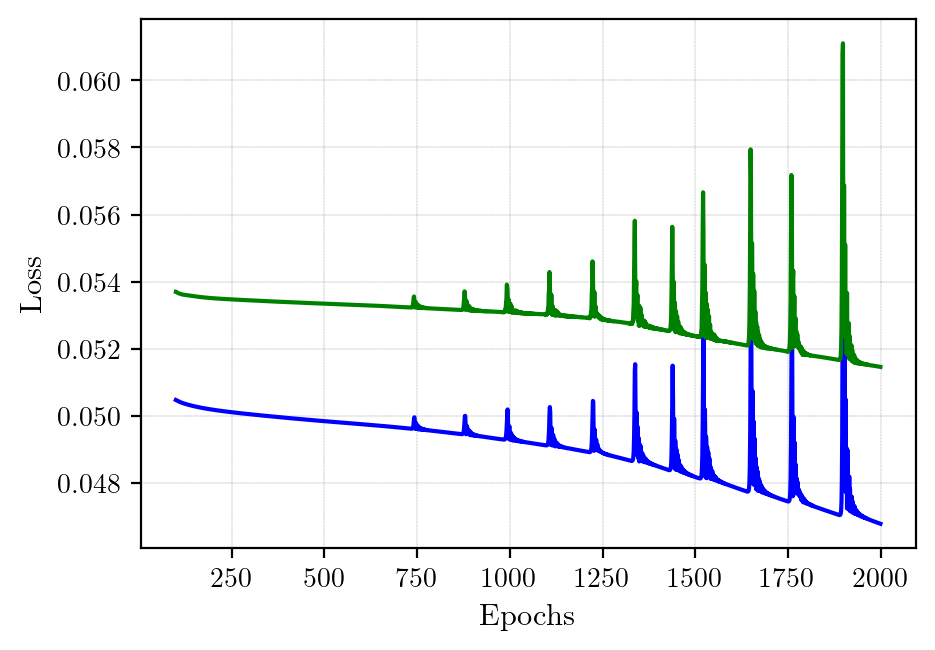

In [77]:
df_file = 'C:\\Users\\John\\Documents\\Research\\ML_Gravity\\Data\\Dataframes\\dummy.data'
#config = get_fast_earth_pinn_config()
config = get_fast_earth_pinn_config()
config['epochs'] = [2000]
config['batch_size'] = [1024]
config['N_train'] = [1000]
config['optimizer'] = [tf.keras.optimizers.Adam(lr=0.001)] # 10x
config['PINN_flag'] = ['laplacian']
config['mixed_precision'] = [False]
pipeline(df_file, config)

Found existing acceleration.data at C:\Users\John\Documents\Research\ML_Gravity\GravNN\Trajectories\TrajectoryBase/../../Files/Trajectories/RandomDist/earthN_1000000_RadBounds[6378136.6, 6798136.6]/SphericalHarmonics_EGM2008_to2190_TideFree_E_1000/
Found existing acceleration.data at C:\Users\John\Documents\Research\ML_Gravity\GravNN\Trajectories\TrajectoryBase/../../Files/Trajectories/RandomDist/earthN_1000000_RadBounds[6378136.6, 6798136.6]/SphericalHarmonics_EGM2008_to2190_TideFree_E_2/
Epoch: 0 	 Loss: 0.31395 	 Val Loss 0.58417 	 Time: 5.269
Epoch: 10 	 Loss: 0.08426 	 Val Loss 0.08384 	 Time: 0.222
Epoch: 20 	 Loss: 0.06250 	 Val Loss 0.06223 	 Time: 0.226
Epoch: 30 	 Loss: 0.05315 	 Val Loss 0.05609 	 Time: 0.222
Epoch: 40 	 Loss: 0.05119 	 Val Loss 0.05390 	 Time: 0.230
Epoch: 50 	 Loss: 0.05061 	 Val Loss 0.05376 	 Time: 0.221
Epoch: 60 	 Loss: 0.05042 	 Val Loss 0.05358 	 Time: 0.229
Epoch: 70 	 Loss: 0.05032 	 Val Loss 0.05346 	 Time: 0.229
Epoch: 80 	 Loss: 0.05026 	 Val Lo

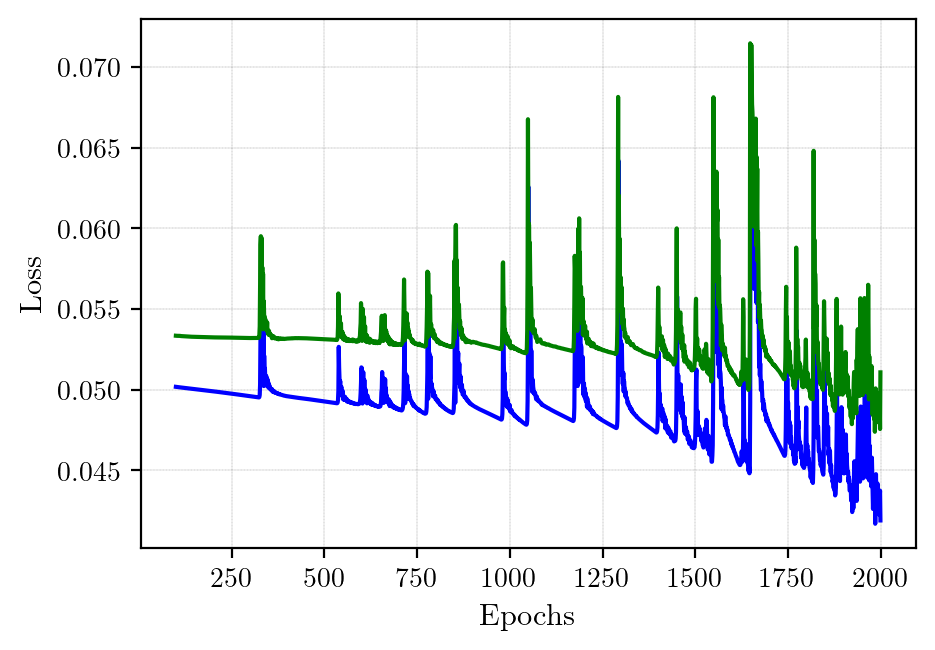

In [75]:
df_file = 'C:\\Users\\John\\Documents\\Research\\ML_Gravity\\Data\\Dataframes\\dummy.data'
#config = get_fast_earth_pinn_config()
config = get_fast_earth_pinn_config()
config['epochs'] = [2000]
config['batch_size'] = [1024]
config['N_train'] = [1000]
config['optimizer'] = [tf.keras.optimizers.Adam(lr=0.01)] # 10x
config['PINN_flag'] = ['laplacian']
config['mixed_precision'] = [False]
pipeline(df_file, config)

Found existing acceleration.data at C:\Users\John\Documents\Research\ML_Gravity\GravNN\Trajectories\TrajectoryBase/../../Files/Trajectories/RandomDist/earthN_1000000_RadBounds[6378136.6, 6798136.6]/SphericalHarmonics_EGM2008_to2190_TideFree_E_1000/
Found existing acceleration.data at C:\Users\John\Documents\Research\ML_Gravity\GravNN\Trajectories\TrajectoryBase/../../Files/Trajectories/RandomDist/earthN_1000000_RadBounds[6378136.6, 6798136.6]/SphericalHarmonics_EGM2008_to2190_TideFree_E_2/
Epoch: 0 	 Loss: 0.30927 	 Val Loss 0.21482 	 Time: 4.669
Epoch: 10 	 Loss: 0.11441 	 Val Loss 0.11589 	 Time: 0.224
Epoch: 20 	 Loss: 0.10452 	 Val Loss 0.10692 	 Time: 0.224
Epoch: 30 	 Loss: 0.10065 	 Val Loss 0.10323 	 Time: 0.223
Epoch: 40 	 Loss: 0.09814 	 Val Loss 0.10079 	 Time: 0.225
Epoch: 50 	 Loss: 0.09613 	 Val Loss 0.09883 	 Time: 0.221
Epoch: 60 	 Loss: 0.09438 	 Val Loss 0.09712 	 Time: 0.224
Epoch: 70 	 Loss: 0.09281 	 Val Loss 0.09558 	 Time: 0.263
Epoch: 80 	 Loss: 0.09138 	 Val Lo

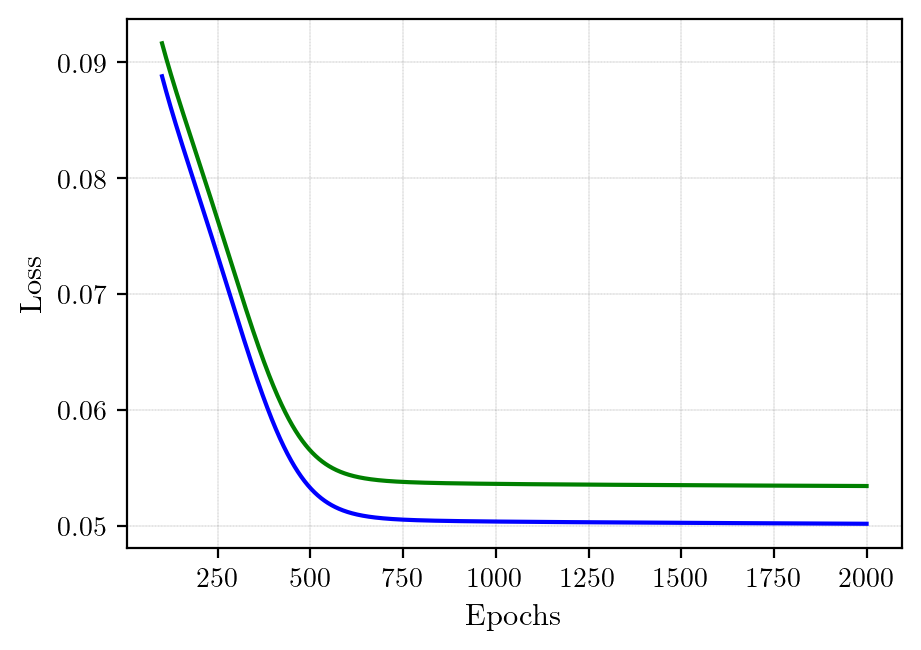

In [76]:
df_file = 'C:\\Users\\John\\Documents\\Research\\ML_Gravity\\Data\\Dataframes\\dummy.data'
#config = get_fast_earth_pinn_config()
config = get_fast_earth_pinn_config()
config['epochs'] = [2000]
config['batch_size'] = [1024]
config['N_train'] = [1000]
config['optimizer'] = [tf.keras.optimizers.SGD()] # 
config['PINN_flag'] = ['laplacian']
config['mixed_precision'] = [False]
pipeline(df_file, config)

# Smaller Batch Sizes
## Improves performance

Found existing acceleration.data at C:\Users\John\Documents\Research\ML_Gravity\GravNN\Trajectories\TrajectoryBase/../../Files/Trajectories/RandomDist/earthN_1000000_RadBounds[6378136.6, 6798136.6]/SphericalHarmonics_EGM2008_to2190_TideFree_E_1000/
Found existing acceleration.data at C:\Users\John\Documents\Research\ML_Gravity\GravNN\Trajectories\TrajectoryBase/../../Files/Trajectories/RandomDist/earthN_1000000_RadBounds[6378136.6, 6798136.6]/SphericalHarmonics_EGM2008_to2190_TideFree_E_2/
Epoch: 0 	 Loss: 0.05898 	 Val Loss 0.05475 	 Time: 1.918
Epoch: 10 	 Loss: 0.04307 	 Val Loss 0.04766 	 Time: 5.054
Epoch: 20 	 Loss: 0.03175 	 Val Loss 0.03820 	 Time: 5.027
Epoch: 30 	 Loss: 0.02649 	 Val Loss 0.03317 	 Time: 4.999
Epoch: 40 	 Loss: 0.02100 	 Val Loss 0.02691 	 Time: 5.004
Epoch: 50 	 Loss: 0.01758 	 Val Loss 0.02217 	 Time: 4.998
Epoch: 60 	 Loss: 0.01579 	 Val Loss 0.02000 	 Time: 5.044
Epoch: 70 	 Loss: 0.01477 	 Val Loss 0.01901 	 Time: 5.038
Epoch: 80 	 Loss: 0.01401 	 Val Lo

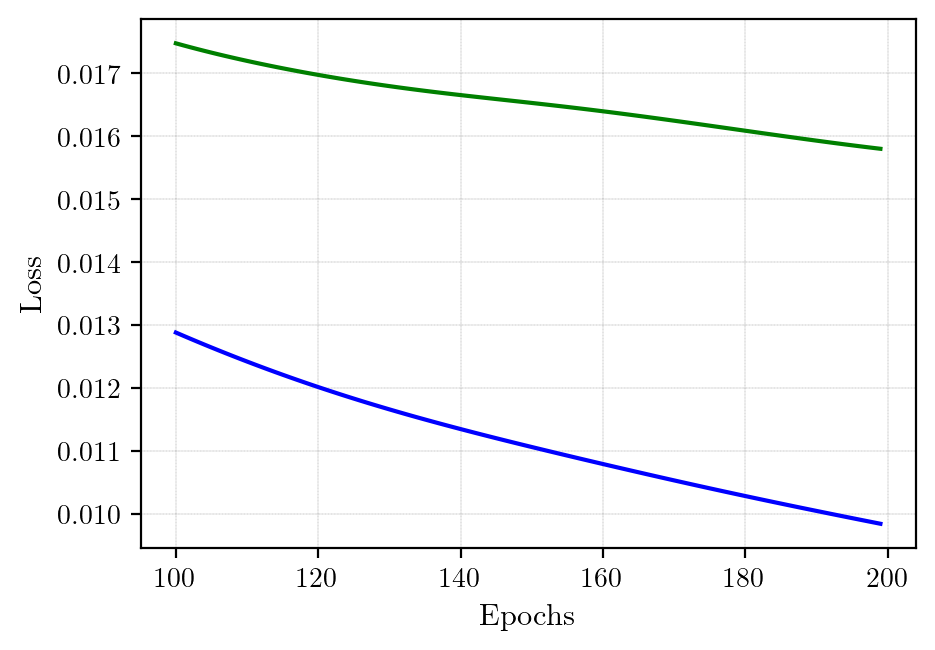

In [61]:
df_file = 'C:\\Users\\John\\Documents\\Research\\ML_Gravity\\Data\\Dataframes\\dummy.data'
#config = get_fast_earth_pinn_config()
config = get_fast_earth_config()
config['epochs'] = [200]
config['batch_size'] = [16]
config['N_train'] = [1000]
config['PINN_flag'] = ['none']
config['mixed_precision'] = [False]
pipeline(df_file, config)

Found existing acceleration.data at C:\Users\John\Documents\Research\ML_Gravity\GravNN\Trajectories\TrajectoryBase/../../Files/Trajectories/RandomDist/earthN_1000000_RadBounds[6378136.6, 6798136.6]/SphericalHarmonics_EGM2008_to2190_TideFree_E_1000/
Found existing acceleration.data at C:\Users\John\Documents\Research\ML_Gravity\GravNN\Trajectories\TrajectoryBase/../../Files/Trajectories/RandomDist/earthN_1000000_RadBounds[6378136.6, 6798136.6]/SphericalHarmonics_EGM2008_to2190_TideFree_E_2/
Epoch: 0 	 Loss: 0.05675 	 Val Loss 0.05344 	 Time: 2.328
Epoch: 10 	 Loss: 0.02874 	 Val Loss 0.03297 	 Time: 5.754
Epoch: 20 	 Loss: 0.02250 	 Val Loss 0.02730 	 Time: 5.618
Epoch: 30 	 Loss: 0.02030 	 Val Loss 0.02475 	 Time: 5.615
Epoch: 40 	 Loss: 0.01848 	 Val Loss 0.02306 	 Time: 5.633
Epoch: 50 	 Loss: 0.01712 	 Val Loss 0.02208 	 Time: 5.629
Epoch: 60 	 Loss: 0.01604 	 Val Loss 0.02118 	 Time: 5.615
Epoch: 70 	 Loss: 0.01520 	 Val Loss 0.02037 	 Time: 5.624
Epoch: 80 	 Loss: 0.01458 	 Val Lo

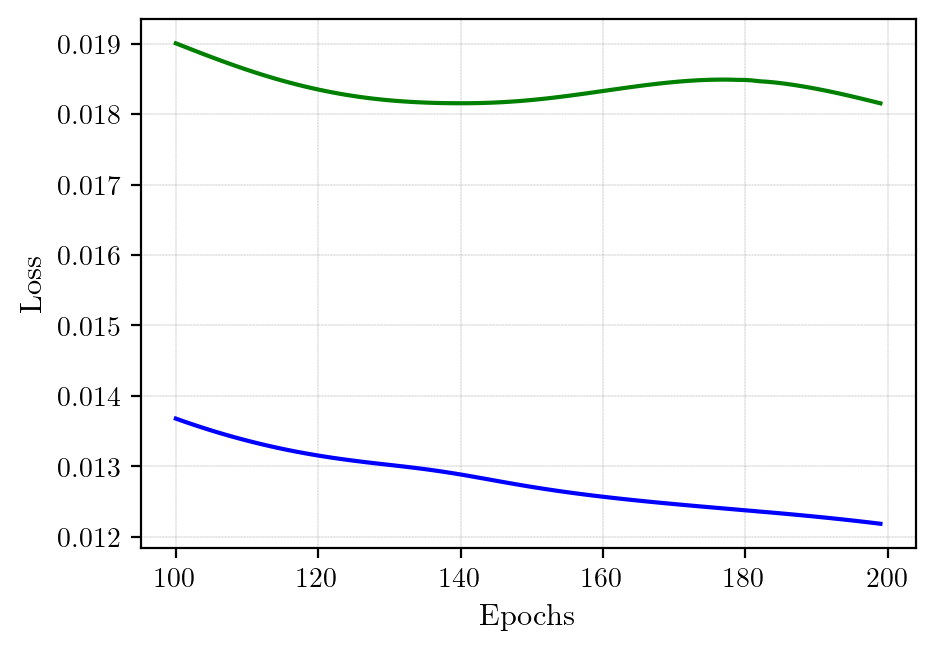

In [63]:
df_file = 'C:\\Users\\John\\Documents\\Research\\ML_Gravity\\Data\\Dataframes\\dummy.data'
#config = get_fast_earth_pinn_config()
config = get_fast_earth_pinn_config()
config['epochs'] = [200]
config['batch_size'] = [16]
config['N_train'] = [1000]
config['PINN_flag'] = ['gradient']
config['mixed_precision'] = [False]
pipeline(df_file, config)

Found existing acceleration.data at C:\Users\John\Documents\Research\ML_Gravity\GravNN\Trajectories\TrajectoryBase/../../Files/Trajectories/RandomDist/earthN_1000000_RadBounds[6378136.6, 6798136.6]/SphericalHarmonics_EGM2008_to2190_TideFree_E_1000/
Found existing acceleration.data at C:\Users\John\Documents\Research\ML_Gravity\GravNN\Trajectories\TrajectoryBase/../../Files/Trajectories/RandomDist/earthN_1000000_RadBounds[6378136.6, 6798136.6]/SphericalHarmonics_EGM2008_to2190_TideFree_E_2/
Epoch: 0 	 Loss: 0.07093 	 Val Loss 0.05768 	 Time: 7.557
Epoch: 10 	 Loss: 0.05122 	 Val Loss 0.05379 	 Time: 8.779
Epoch: 20 	 Loss: 0.05085 	 Val Loss 0.05364 	 Time: 9.017
Epoch: 30 	 Loss: 0.05077 	 Val Loss 0.05362 	 Time: 9.179
Epoch: 40 	 Loss: 0.05073 	 Val Loss 0.05360 	 Time: 8.784
Epoch: 50 	 Loss: 0.05069 	 Val Loss 0.05358 	 Time: 9.221
Epoch: 60 	 Loss: 0.05066 	 Val Loss 0.05356 	 Time: 9.066
Epoch: 70 	 Loss: 0.05062 	 Val Loss 0.05354 	 Time: 9.391
Epoch: 80 	 Loss: 0.05060 	 Val Lo

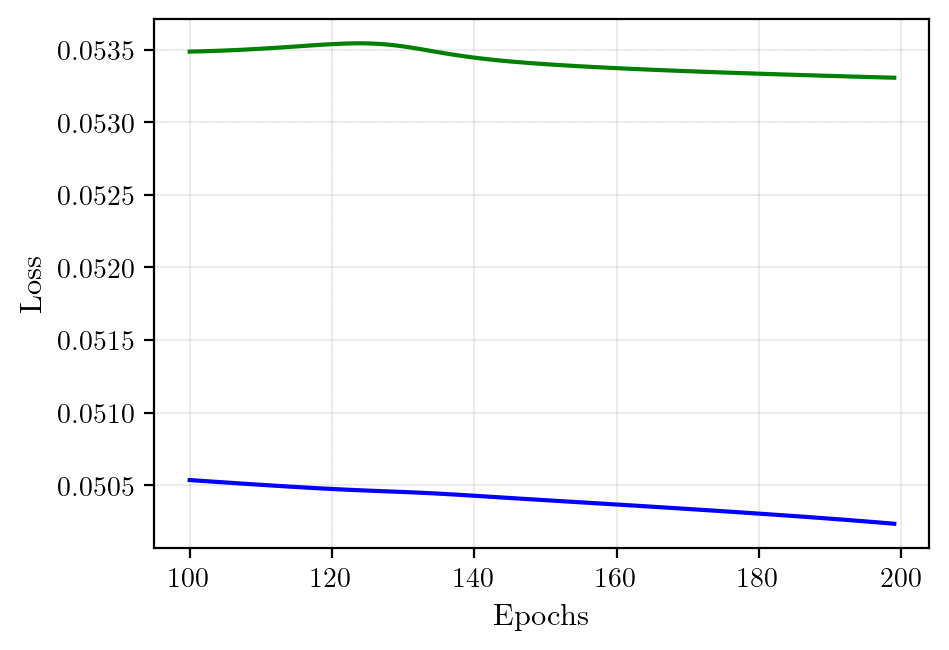

In [62]:
df_file = 'C:\\Users\\John\\Documents\\Research\\ML_Gravity\\Data\\Dataframes\\dummy.data'
#config = get_fast_earth_pinn_config()
config = get_fast_earth_pinn_config()
config['epochs'] = [200]
config['batch_size'] = [16]
config['N_train'] = [1000]
config['PINN_flag'] = ['laplacian']
config['mixed_precision'] = [False]
pipeline(df_file, config)

# Smallest Batch Size

Found existing acceleration.data at C:\Users\John\Documents\Research\ML_Gravity\GravNN\Trajectories\TrajectoryBase/../../Files/Trajectories/RandomDist/earthN_1000000_RadBounds[6378136.6, 6798136.6]/SphericalHarmonics_EGM2008_to2190_TideFree_E_1000/
Found existing acceleration.data at C:\Users\John\Documents\Research\ML_Gravity\GravNN\Trajectories\TrajectoryBase/../../Files/Trajectories/RandomDist/earthN_1000000_RadBounds[6378136.6, 6798136.6]/SphericalHarmonics_EGM2008_to2190_TideFree_E_2/
Epoch: 0 	 Loss: 0.08830 	 Val Loss 0.08246 	 Time: 7.207
Epoch: 10 	 Loss: 0.06994 	 Val Loss 0.07763 	 Time: 69.179
Epoch: 20 	 Loss: 0.06246 	 Val Loss 0.07176 	 Time: 64.878
Epoch: 30 	 Loss: 0.05748 	 Val Loss 0.06842 	 Time: 64.544
Epoch: 40 	 Loss: 0.05142 	 Val Loss 0.06539 	 Time: 61.853
INFO:tensorflow:Assets written to: C:\Users\John\Documents\Research\ML_Gravity/Data/Networks/2459261.3657523147/network\assets
Found existing acceleration.data at C:\Users\John\Documents\Research\ML_Gravity\

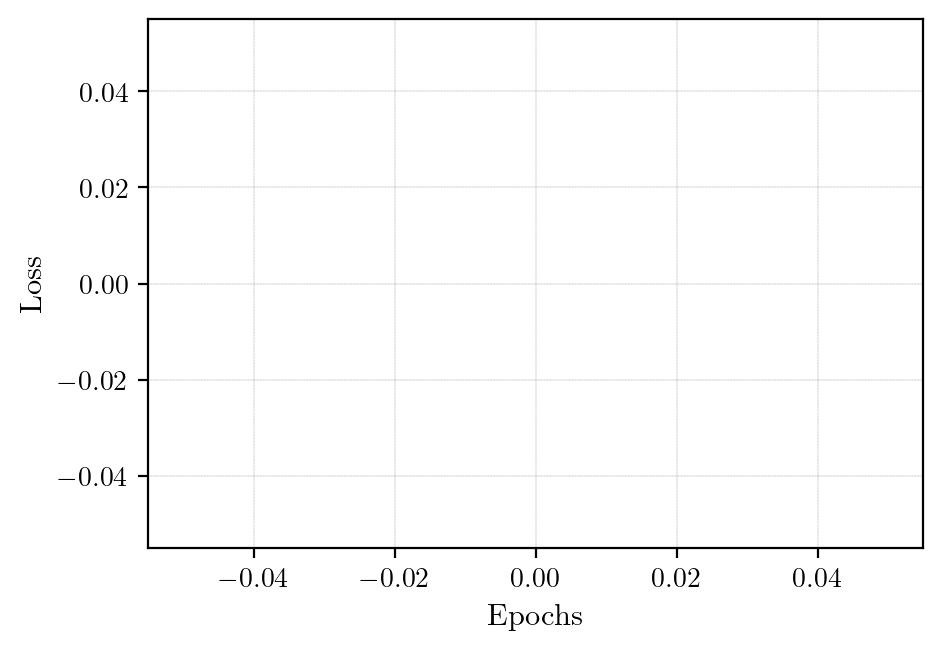

In [68]:
df_file = 'C:\\Users\\John\\Documents\\Research\\ML_Gravity\\Data\\Dataframes\\dummy.data'
#config = get_fast_earth_pinn_config()
config = get_fast_earth_config()
config['epochs'] = [50]
config['layers'] = [[3, 10, 10, 10, 10, 3]]
config['batch_size'] = [1]
config['N_train'] = [400]
config['PINN_flag'] = ['none']
config['mixed_precision'] = [False]
pipeline(df_file, config)

In [ ]:
df_file = 'C:\\Users\\John\\Documents\\Research\\ML_Gravity\\Data\\Dataframes\\dummy.data'
#config = get_fast_earth_pinn_config()
config = get_fast_earth_pinn_config()
config['epochs'] = [50]
config['layers'] =  [[3, 10, 10, 10, 10, 1]]
config['batch_size'] = [1]
config['N_train'] = [400]
config['PINN_flag'] = ['laplacian']
config['mixed_precision'] = [False]
pipeline(df_file, config)